In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
import pandas as pd
import numpy as np
import os

In [2]:
def gillespieSIRV(G, beta, mu, t_max, strategies):
    '''
    This function simulates a SIRV process on a Graph G using the Gillespie algorithm
    
    Arguments:
    
    G        : graph on which to operate
    beta     : transmissibility of the disease
    mu       : recovery rate of the disease
    t_max    : t_max of the simulation
    strategies : list with strategies node adopts, can be either vaccinated or susceptible 
    
    OUTPUT:
    results:
       -time at which system changed status
       -S : fraction of Susceptible
       -I : fraction of Infected
       -R : fraction of Recovered
       -V : vaccined people, not susceptible and look like recovered
    '''
    
    statuses = strategies.copy()
    
    #INITIALIZATION VARIABLES
    N = nx.number_of_nodes(G)
    S = statuses.count('S')
    I = 0
    R = 0
    V = statuses.count('V')
    
    infected_nodes = set()
    at_risk_nodes  = set()
    
    infection_rate = np.zeros((N))
    infection_rate_prob = []
    
    columns = ['Time', 'S', 'I', 'R', 'V']
    results = pd.DataFrame(columns=columns)
    
    
    #Set the seed, select a node at random with the condition that must be susceptible to start the infection
    while True:
        seed = np.random.choice(range(len(statuses)))
        if statuses[seed] == 'S':
            break
            
    #add the seed to infected nodes and update accordingly
    infected_nodes.add(seed)
    statuses[seed] = 'I'
    S = S-1
    I = I+1
    
    #update the "at risk nodes", but first check whether it's vaccined
    for i in G.neighbors(seed):
        #if it is not vaccined, then it is susceptible and add it to risk nodes
        if statuses[seed] != 'V': 
            at_risk_nodes.add(i)
            infection_rate_prob.append(i)
            infection_rate[i] += beta
        #if it is vaccined, then skip
        else: continue
    
    #computes the rates of the next event
    total_infection_rate = np.sum(infection_rate)
    total_recovery_rate = mu*float(len(infected_nodes))
    total_rate = total_infection_rate + total_recovery_rate
    
    results.loc[len(results)] = [0.0,
                                 S/float(N),
                                 I/float(N),
                                 R/float(N),
                                 V/float(N)]
    
    #timing of the first event
    time = np.random.exponential(1.0/total_rate)

    #dynamic starts
    #while time < t_max and total_rate > 0:
    while total_rate > 0:
        
        #draw a random number between 0 and total rate 
        #total rate = infection rate + recovery rate
        rnd = np.random.uniform(0, total_rate)
        
        #recovery phase
        if rnd < total_recovery_rate:
            
            node = np.random.choice(list(infected_nodes))
            infected_nodes.remove(node)
            statuses[node] = 'R'
            I = I - 1
            R = R + 1 
            
            for i in G.neighbors(node):
                
                if statuses[i] == 'S':
                    
                    infection_rate[i] -= beta
                    
                    #needed, check 
                    if infection_rate[i] == 0.0:
                        at_risk_nodes.remove(i)
                    
                    infection_rate_prob.remove(i)
        else:
            
            #infection phase
            node = np.random.choice(infection_rate_prob)
            
            at_risk_nodes.remove(node)
            infected_nodes.add(node)
            
            infection_rate[node] = 0.0
            #infection_rate_prob.remove(node)
            infection_rate_prob  = [j for j in infection_rate_prob if j != node]

            statuses[node] = 'I'
            S = S - 1
            I = I + 1
            
            for i in G.neighbors(node):
                
                if statuses[i] == 'S':
                    
                    at_risk_nodes.add(i)
                    infection_rate[i] += beta
                    infection_rate_prob.append(i)
                        
        results.loc[len(results)] = [time,
                            S/float(N),
                            I/float(N),
                            R/float(N),
                            V/float(N)]
        
        #computes rates for the next event
        total_infection_rate = np.sum(infection_rate)
        total_recovery_rate  = mu*float(len(infected_nodes))
        total_rate = total_infection_rate + total_recovery_rate
        
        if total_rate > 0:
            time += np.random.exponential(1.0/total_rate)
    
    return results, statuses

def map_status_to_value(statuses_list):
    vals = []
    for i in statuses_list:
        if i == 'V':
            vals.append(0)
        elif i == 'S':
            vals.append(1)
        elif i == 'I':
            vals.append(2)
        elif i == 'R':
            vals.append(3)
        
    return np.array(vals)

def get_threshold_immunity(beta, mu, av_k):
    herd_threshold = 1 - (av_k*beta/mu)**(-1)
    print(f"Herd immunity threshold is: {herd_threshold}")
    
    return herd_threshold

#Strategy Adaptation: The Original Individual-Based Risk Assessment (IB-RA)
def IB_RA_update(old_strategy, payoff_list, G):
    
    #Initialize the new statuses array
    new_strategy = ['']*len(old_strategy)
    
    for i in range(len(old_strategy)):
        i_node_payoff = payoff_list[i]
        #pick a neighbor of node i at random
        neighbor = np.random.choice(list(G.neighbors(i)))
        #compute the probability to flip the status of a node
        prob = Fermi_function( i_node_payoff - payoff_list[neighbor]) 
        if np.random.random() < prob:
            #copy the strategy of the other node
            new_strategy[i]  = old_strategy[neighbor]
        #else do nothing and keep the same strategy
        else: new_strategy[i]  = old_strategy[i]
    
    return new_strategy

#update using The Strategy-Based Risk Assessment (SB-RA)
def SB_RA_update(old_strategy, payoff_list, G, sampling_param):
    
    #Initialize the new statuses array
    new_strategy = ['']*len(old_strategy)

    for i in range(len(old_strategy)):
        i_node_payoff = payoff_list[i]
        
        #pick a neighbor of node i at random, this will be "j" in the formula
        neighbor = np.random.choice(list(G.neighbors(i)))
        
        #expected payoff for a vaccined node is the one of all vaccined (e.g. -C_r)
        if old_strategy[neighbor] == 'V':
            neighbor_payoff = i_node_payoff
        #if neighbour node was not vaccined, then look at the others node that were not vaccined 
        #(up to sampling parameter) and compute an "average" payoff for not being vaccined 
        elif old_strategy[neighbor] == 'S':
            neighbor_payoff = 0
            #if sampling parameter is zero then use the whole network
            if (sampling_param == 0):
                #number of -1 in the payoff are the people who didn't vaccine and got infected
                infected = (payoff_list == -1).sum()
                #number of 0 in the payoff are free riders
                free_riders = (payoff_list == 0).sum()
                neighbor_payoff = -infected/(infected+free_riders)
            #if sampling parameter is 1 then go back to the IB-RA case and use the j-th neighbor payoff
            elif (sampling_param == 1):
                neighbor_payoff = payoff_list[neighbor]
            else:
            #if sampling parameter is more than 1 then pick a number "sampling parameter" nodes that didn't vaccine
            #and see which is their payoff. Then, take the average.
                indices = [i for i, x in enumerate(old_strategy) if x == "S"]
                for j in range(sampling_param):
                    neighbor_payoff += payoff_list[np.random.choice(indices)]
                neighbor_payoff /= sampling_param
                
        #compute the probability to flip the status of a node
        prob = Fermi_function( i_node_payoff - neighbor_payoff) 
        if np.random.random() < prob:
            #copy the strategy of the other node
            new_strategy[i]  = old_strategy[neighbor]
        #else do nothing and keep the same strategy
        else: new_strategy[i]  = old_strategy[i]
    
    return new_strategy

def get_payoff(statuses, cost_vacc, N):
    payoff = []
    
    for i in statuses:
        if   i == 'S': payoff.append(0.)
        elif i == 'R': payoff.append(-1.)
        elif i == 'V': payoff.append(-cost_vacc)
            
    return np.array(payoff)

#k is the selection pressure, i.e. the lower the more sensible they are wrt the payoff difference
def Fermi_function(x, k = 0.1):
    return(1./(1. + np.exp(x/k)))

def plot_strategy_square_lattice(strategy, N, title = '', saveflag = False, iteration = '', update_rule = 'update', Cr = '' ):
    
    values = map_status_to_value(strategy).reshape((N,N))
    
    #individual can only cooperate (blue) or defect (red)
    cMap = ListedColormap(['blue', 'red'])
    
    fig, ax = plt.subplots(figsize = (8,8))
    img = ax.imshow(values, cmap=cMap)

    #legend
    cbar = plt.colorbar(img)
    #empty the ticks of cbar
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['C', 'D']):
        cbar.ax.text(0.5, 0.30 + 0.45*j, lab, ha = 'center', va ='center', fontsize = '25')
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Strategy', rotation = 90, fontsize = '25')

    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xlim([-.5,float(N)-0.5])
    ax.set_ylim([-.5,float(N)-0.5])
    
    #set the ticks properly
    ax.set_xticks(np.arange(-.5, N , 1))
    ax.set_yticks(np.arange(-.5, N , 1))
    
    #empty the ticks of the picture/fig
    empty_string_labels = ['']*len(np.arange(-.5, N , 1))
    ax.set_xticklabels(empty_string_labels)
    ax.set_yticklabels(empty_string_labels)
    ax.invert_yaxis()
    ax.set_title(str(title), fontsize = '25')
    if (saveflag):
        if (iteration == ''):
            output_dir = 'Cr_'+str(Cr)+'/'+update_rule+"/"
            os.makedirs(output_dir,exist_ok=True)
            plt.savefig(output_dir+'strategy.png')
            plt.close()
        else:  
            output_dir = 'Cr_'+str(Cr)+'/'+update_rule+"/"
            os.makedirs(output_dir,exist_ok=True)
            plt.savefig(output_dir+'strategy'+str(iteration)+'.png')
            plt.close()
    else:  
        plt.show()    
    return

def plot_SIRV_results_square_lattice(statuses, N, saveflag = False, iteration = '', update_rule = 'update', Cr = '' ):
    
    values = map_status_to_value(statuses).reshape((N,N))
    cMap = ListedColormap(['white', 'green', 'yellow','red'])
    
    fig, ax = plt.subplots(figsize = (10,10))
    img = ax.imshow(values, cmap=cMap)

    #legend
    cbar = plt.colorbar(img)
    #empty the ticks of cbar
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['V', 'S', 'I', 'R']):
        cbar.ax.text(1.5, 0.75*j+0.35, lab, ha='center', va ='center', fontsize = '25')
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Node type', rotation=90, fontsize = '25')

    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xlim([-.5,float(N)-0.5])
    ax.set_ylim([-.5,float(N)-0.5])
    
    #set the ticks properly
    ax.set_xticks(np.arange(-.5, N , 1))
    ax.set_yticks(np.arange(-.5, N , 1))
    
    #empty the ticks of the picture/fig
    empty_string_labels = ['']*len(np.arange(-.5, N , 1))
    ax.set_xticklabels(empty_string_labels)
    ax.set_yticklabels(empty_string_labels)
    ax.invert_yaxis()
    plt.title('SIRV - final snapshot', fontsize = '25')
    if (saveflag):
        if (iteration == ''):
            output_dir = 'Cr_'+str(Cr)+'/'+update_rule+"/"
            os.makedirs(output_dir,exist_ok=True)
            plt.savefig(output_dir+'/SIRV.png')
            plt.close()
        else:
            output_dir = 'Cr_'+str(Cr)+'/'+update_rule+"/"
            os.makedirs(output_dir,exist_ok=True)
            plt.savefig(output_dir+'/SIRV_iter'+str(iteration)+'.png')
            plt.close()
    else:  
        plt.show()    
    return

# IB_RA update

Vaccination cost is:  0.0
Fraction of population vaccinated is: 0.3976
R_0 of the disease is:
0 / 5
1 / 5
2 / 5
3 / 5
4 / 5


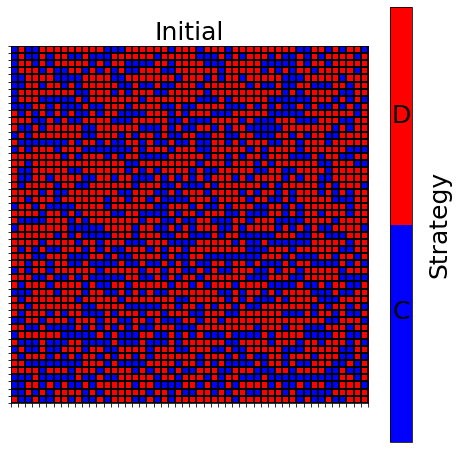

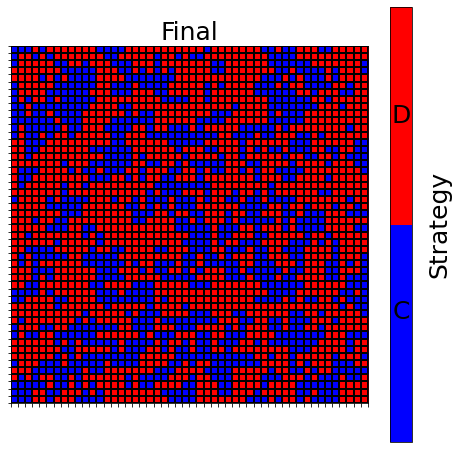

In [3]:
beta = 1.0
mu   = 0.4

for vacc_cost in np.linspace(0. ,1. , 1):
    vacc_cost_str = str(vacc_cost)
    print("Vaccination cost is: ", vacc_cost_str)

    #initialization
    N = 50
    timesteps = 5
    G = nx.grid_2d_graph(N, N)
    G = nx.convert_node_labels_to_integers(G)

    #graph is regular, therefore R_0 = beta*av_k/mu
    av_k     = np.mean([val for (node, val) in G.degree()])
    R_0      = (beta/mu)*av_k
    strategy = nx.number_of_nodes(G)*['S']

    #set initial seed
    np.random.seed(10)

    #initialize randomly
    for i in range(1250):
        seed = np.random.choice(range(len(strategy)))
        strategy[seed] = 'V'
    print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))
    print("R_0 of the disease is:",)

    #initialize the result dataframe
    init_strat = strategy.copy()
    columns = ['Iteration', 'VaccineCoverage', 'TotalInfected', 'MaxInfected', 'AverageSocialPayoff']
    results = pd.DataFrame(columns=columns)

    #dynamics using IB_RA update
    for i in range(timesteps):
        print(i,"/",timesteps)
        df, statuses   = gillespieSIRV(G, beta, mu, 1000, strategy)
        payoffs_values = get_payoff(statuses, vacc_cost, N)
        new_strategies = IB_RA_update(strategy, payoffs_values, G)
        strategy       = new_strategies.copy()

        #update the dataframe
        vacc_cover   = strategy.count('V')/(N*N)
        total_infec  = df.tail(1).R.values[0]
        av_payoff    = np.mean(payoffs_values)
        max_infected = max(df.I)
        results.loc[len(results)] = [i + 1, vacc_cover, total_infec, max_infected, av_payoff]
        
        #plot everything
#         plot_SIRV_results_square_lattice(statuses, N, False, iteration = str(i), update_rule = 'IB_RA', Cr = vacc_cost_str )
#         plot_strategy_square_lattice(strategy, N, '', False, iteration = str(i), update_rule = 'IB_RA', Cr = vacc_cost_str )
        
        
    #results.to_csv('IB_RA_Cr_'+vacc_cost_str+'.csv', index = False)
    plot_strategy_square_lattice(init_strat, N, "Initial", False, iteration = '', update_rule = 'IB_RA', Cr = vacc_cost_str)
    plot_strategy_square_lattice(strategy, N, "Final", False, iteration = '', update_rule = 'IB_RA', Cr = vacc_cost_str)

# SB_RA update

Vaccination cost is:  0.0
Fraction of population vaccinated is: 0.3976
R_0 of the disease is:
0 / 5
1 / 5
2 / 5
3 / 5
4 / 5


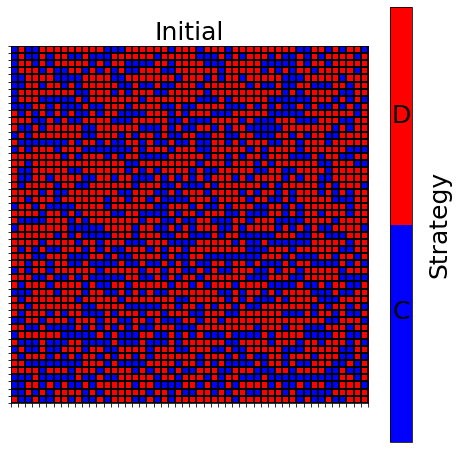

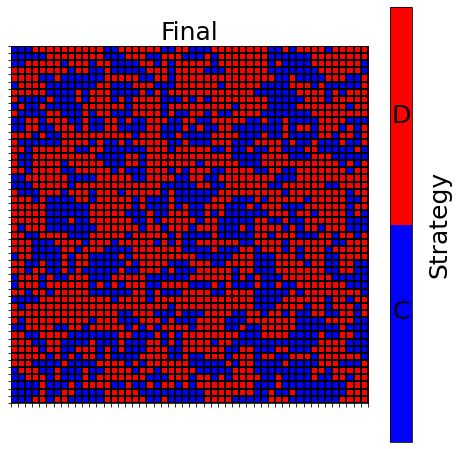

In [4]:
beta = 1.0
mu   = 0.4

for vacc_cost in np.linspace(0. ,1. , 1):
    vacc_cost_str = str(vacc_cost)
    print("Vaccination cost is: ", vacc_cost_str)

    #initialization
    N = 50
    timesteps = 5
    G = nx.grid_2d_graph(N, N)
    G = nx.convert_node_labels_to_integers(G)

    #graph is regular, therefore R_0 = beta*av_k/mu
    av_k     = np.mean([val for (node, val) in G.degree()])
    R_0      = (beta/mu)*av_k
    strategy = nx.number_of_nodes(G)*['S']

    #set initial seed
    np.random.seed(10)

    #initialize randomly
    for i in range(1250):
        seed = np.random.choice(range(len(strategy)))
        strategy[seed] = 'V'
    print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))
    print("R_0 of the disease is:",)

    #initialize the result dataframe
    init_strat = strategy.copy()
    columns = ['Iteration', 'VaccineCoverage', 'TotalInfected', 'MaxInfected', 'AverageSocialPayoff']
    results = pd.DataFrame(columns=columns)

    #dynamics using SB_RA update
    for i in range(timesteps):
        print(i,"/",timesteps)
        df, statuses   = gillespieSIRV(G, beta, mu, 1000, strategy)
        payoffs_values = get_payoff(statuses, vacc_cost, N)
        new_strategies = SB_RA_update(strategy, payoffs_values, G, 0)
        strategy       = new_strategies.copy()

        #update the dataframe
        vacc_cover   = strategy.count('V')/(N*N)
        total_infec  = df.tail(1).R.values[0]
        av_payoff    = np.mean(payoffs_values)
        max_infected = max(df.I)
        results.loc[len(results)] = [i + 1, vacc_cover, total_infec, max_infected, av_payoff]
        
            #plot everything
#         plot_SIRV_results_square_lattice(statuses, N, False, iteration = str(i), update_rule = 'IB_RA', Cr = vacc_cost_str )
#         plot_strategy_square_lattice(strategy, N, '', False, iteration = str(i), update_rule = 'IB_RA', Cr = vacc_cost_str )


#     results.to_csv('SB_RA_Cr_'+vacc_cost_str+'.csv', index = False)
    plot_strategy_square_lattice(init_strat, N, "Initial", False, iteration = '', update_rule = 'SB_RA', Cr = vacc_cost_str)
    plot_strategy_square_lattice(strategy, N, "Final", False, iteration = '', update_rule = 'SB_RA', Cr = vacc_cost_str)

# Result Analysis

In [5]:
def plot_list_dataframes_vs_iteration(df_list, label, Cr_list, update = '', title = ''):
    
    fig, ax = plt.subplots(3,7, figsize = (20,15), sharey = True, sharex = True)
    
    for i, data in enumerate(df_list):
        ax[i//7, i%7].plot(data.Iteration, data.loc[:,str(label)])
        ax[i//7, i%7].set_xlabel('iteration')
        ax[i//7, i%7].set_ylabel(str(label))
        ax[i//7, i%7].set_title(Cr_list[i])
    
    plt.suptitle(str(title), fontsize = '30')
    plt.savefig(update+"_"+title+'.png')
    return

In [6]:
def get_name_csv(mode, Cr):
    return mode+"_Cr_"+Cr+".csv"

IB_RA_dataf = []
SB_RA_dataf = []

for vacc_cost in np.linspace(0. ,1. , 21):
    IB_RA_dataf.append(get_name_csv("IB_RA", str(vacc_cost)))
    SB_RA_dataf.append(get_name_csv("SB_RA", str(vacc_cost)))

#truncate the number as "d.xx"
Cr_list_str = ["{:3.2f}".format(i*0.05) for i in range(21)]
Cr_list     = [float(i) for i in Cr_list_str]

#some are mislabelled therefore set them up manually
IB_RA_dataf[17] = "IB_RA_Cr_0.85.csv"
SB_RA_dataf[17] = "SB_RA_Cr_0.85.csv"
IB_RA_dataf[19] = "IB_RA_Cr_0.95.csv"
SB_RA_dataf[19] = "SB_RA_Cr_0.95.csv"


dataframes_IB_RA = []
dataframes_SB_RA = []

for filename1, filename2 in zip(IB_RA_dataf, SB_RA_dataf):
    dataframes_IB_RA.append(pd.read_csv("content/"+filename1))
    dataframes_SB_RA.append(pd.read_csv("content/"+filename2))

dataframes_IB_RA[4]

,Iteration,VaccineCoverage,TotalInfected,MaxInfected,AverageSocialPayoff
0,1.0,0.2592,0.3396,0.0460,-0.39200
1,2.0,0.1728,0.0736,0.0168,-0.12536
2,3.0,0.0960,0.0716,0.0192,-0.10616
3,4.0,0.1532,0.8636,0.1520,-0.88272
4,5.0,0.0900,0.0012,0.0012,-0.03184
...,...,...,...,...,...
95,96.0,0.2700,0.6828,0.0768,-0.72656
96,97.0,0.2156,0.1136,0.0276,-0.16760
97,98.0,0.2584,0.6912,0.0576,-0.73432
98,99.0,0.2308,0.3528,0.0460,-0.40448


# IB_RA analysis

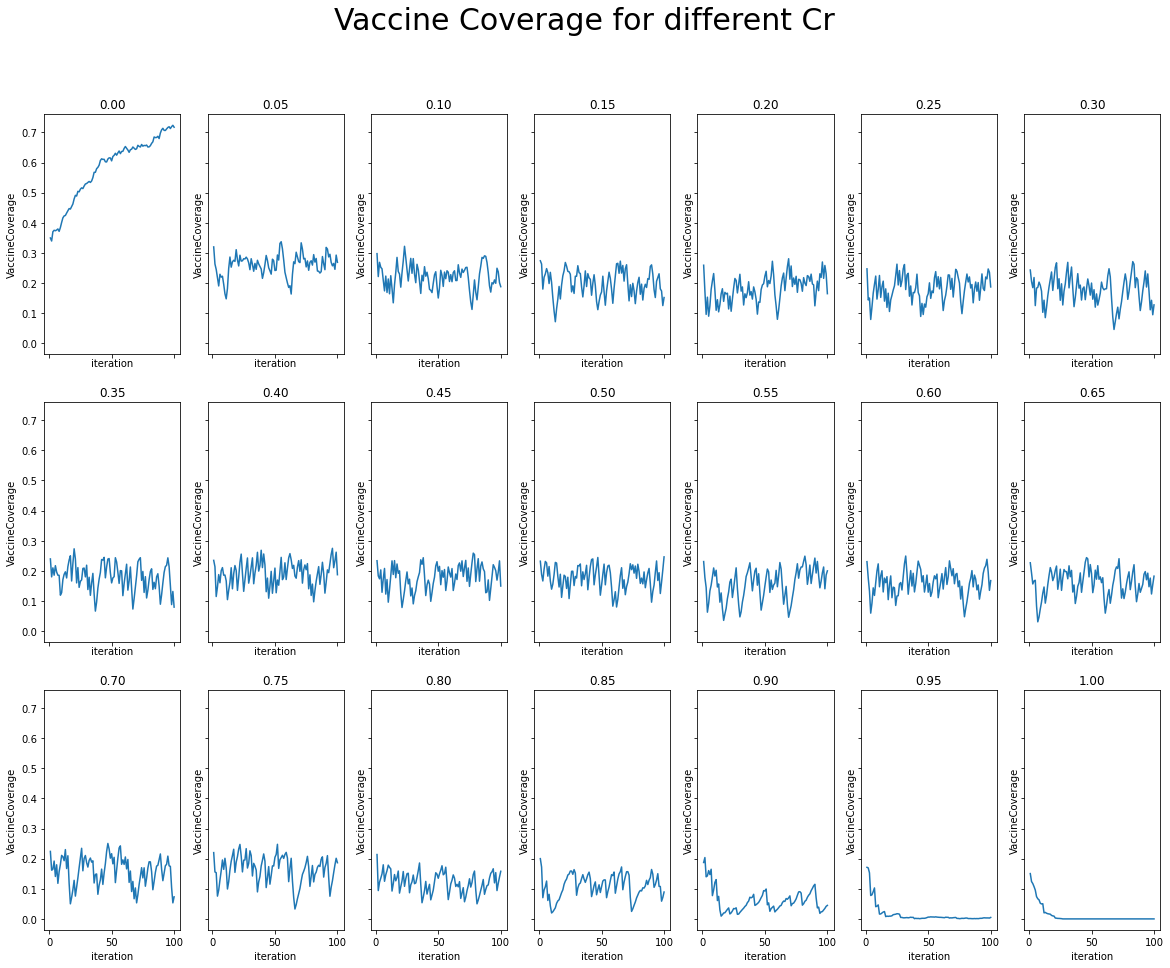

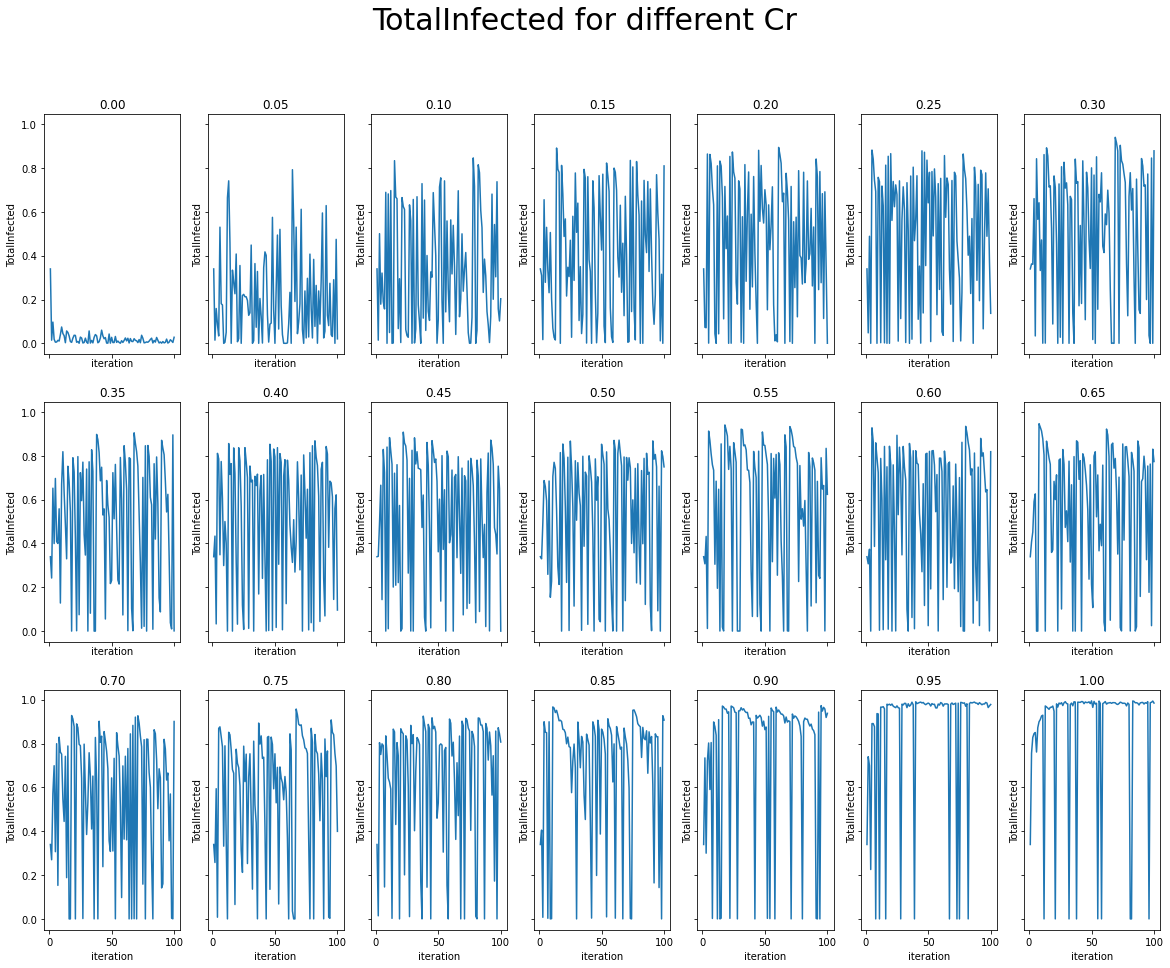

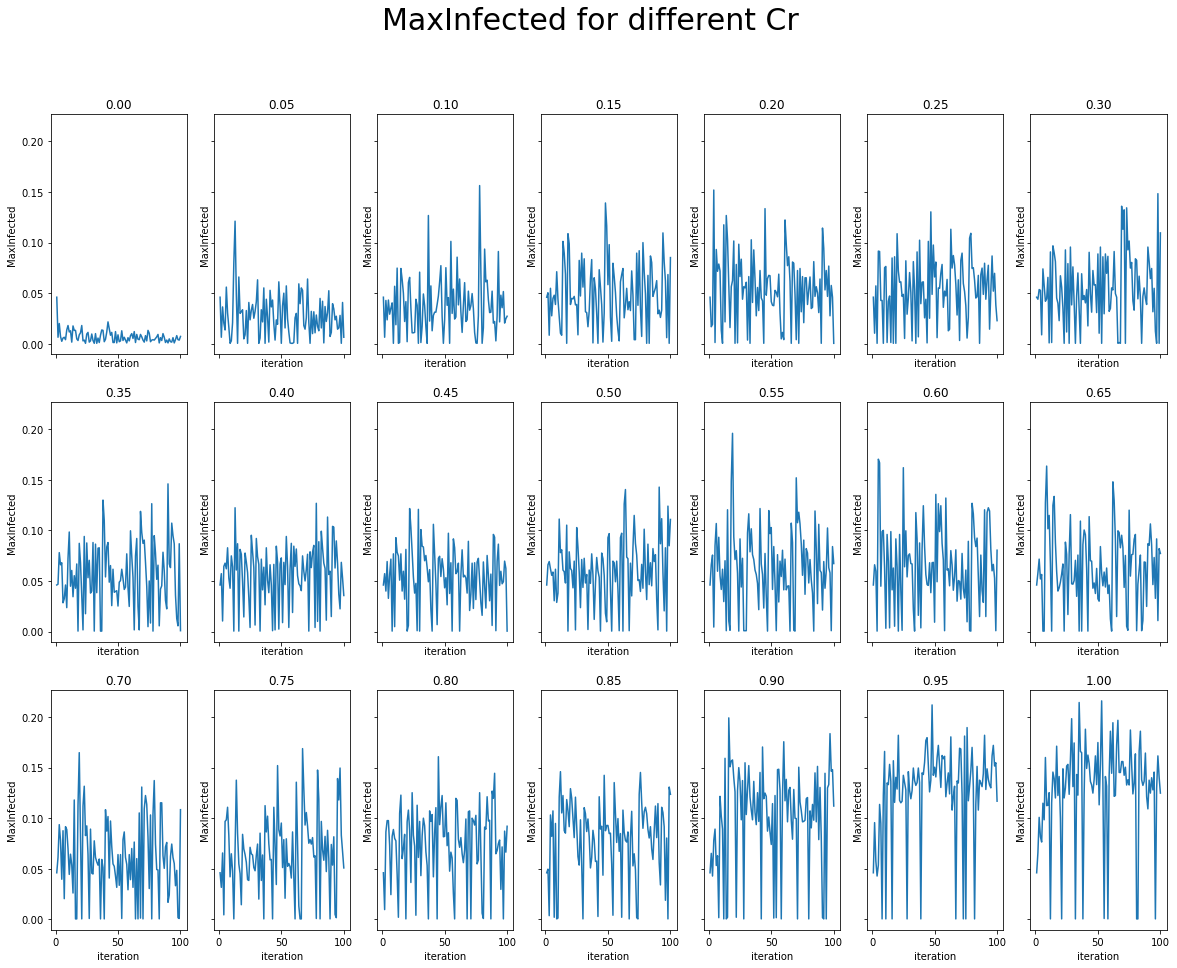

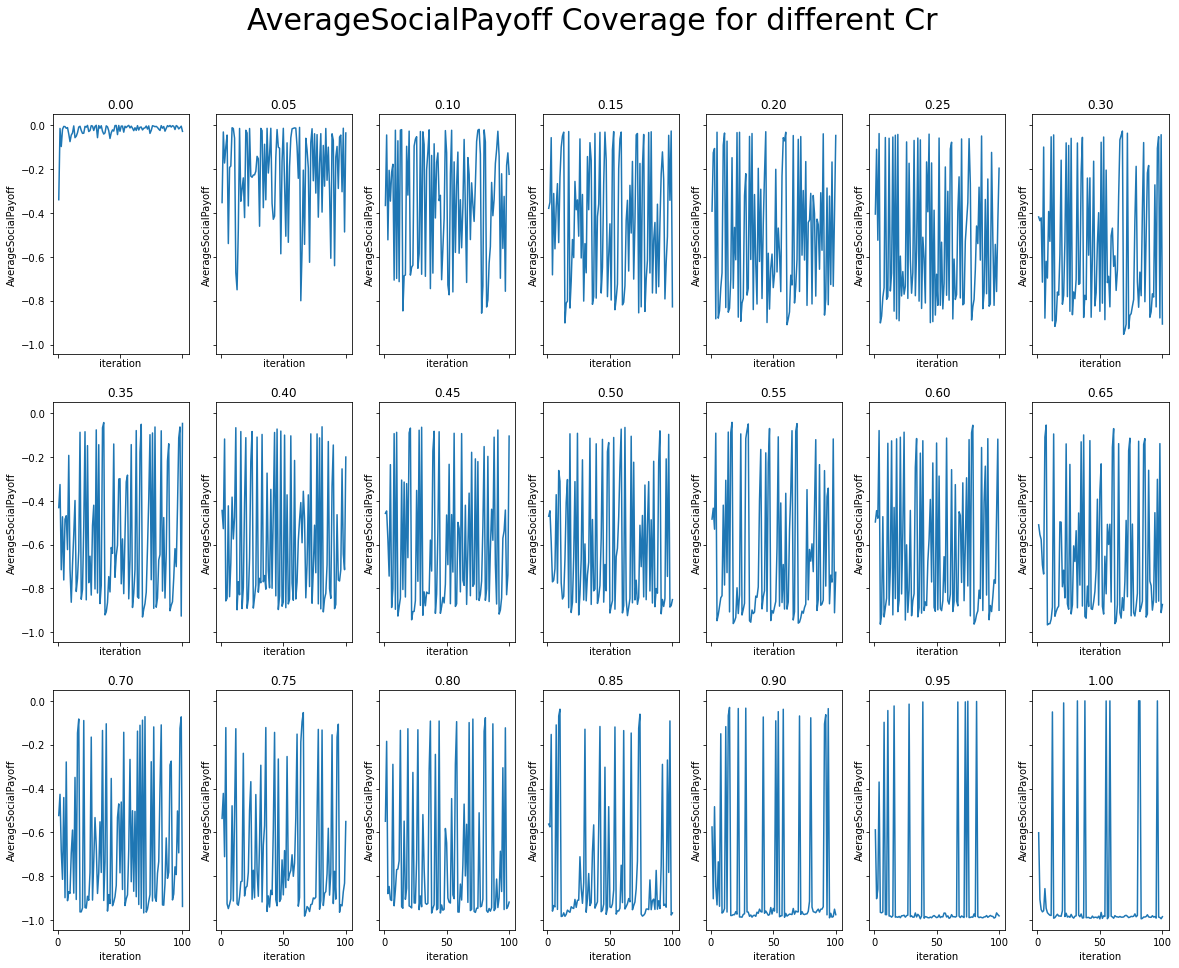

In [7]:
plot_list_dataframes_vs_iteration(dataframes_IB_RA, 'VaccineCoverage', Cr_list_str, 'IB_RA', 'Vaccine Coverage for different Cr')
plot_list_dataframes_vs_iteration(dataframes_IB_RA, 'TotalInfected', Cr_list_str, 'IB_RA' , 'TotalInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_IB_RA, 'MaxInfected', Cr_list_str,  'IB_RA' , 'MaxInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_IB_RA, 'AverageSocialPayoff', Cr_list_str, 'IB_RA' , 'AverageSocialPayoff Coverage for different Cr')

# SB_RA analysis

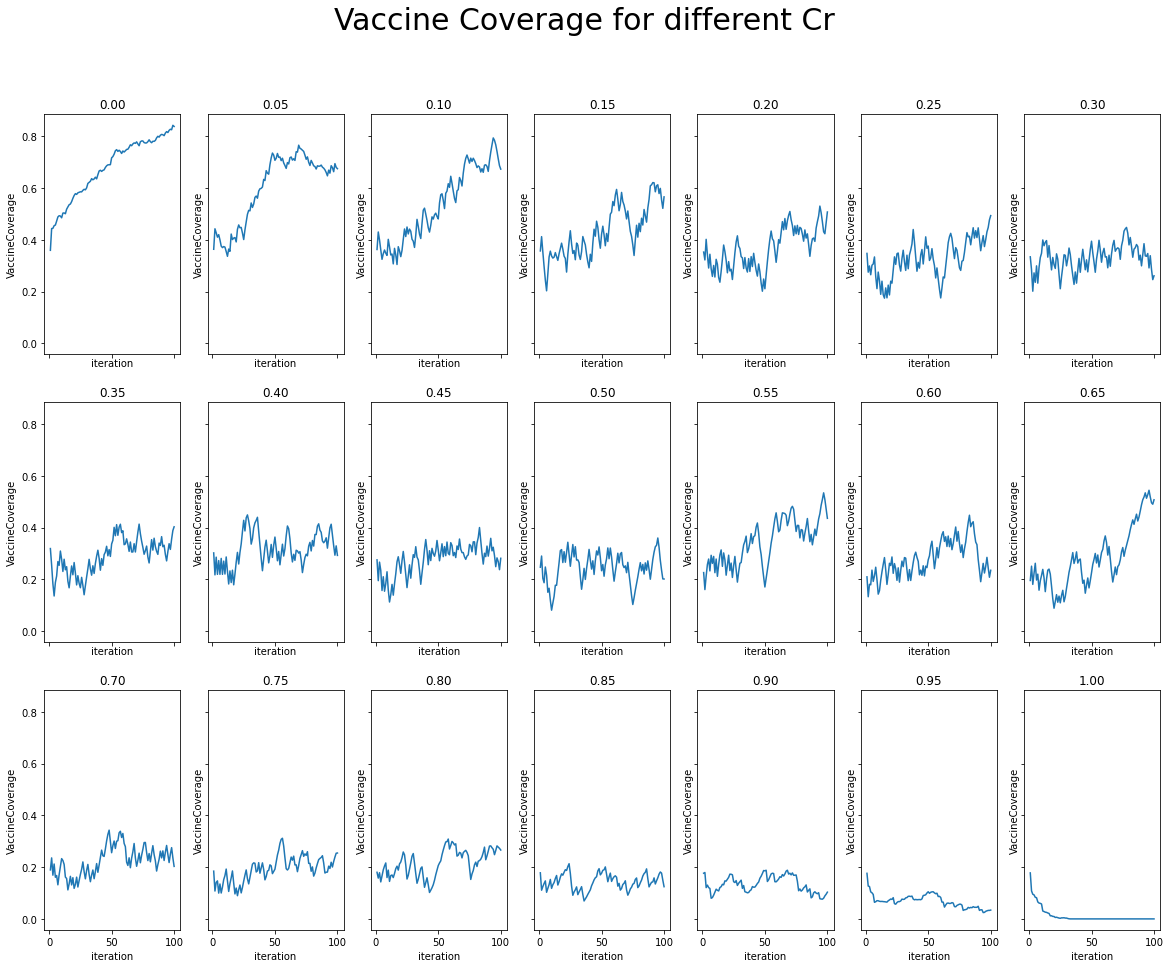

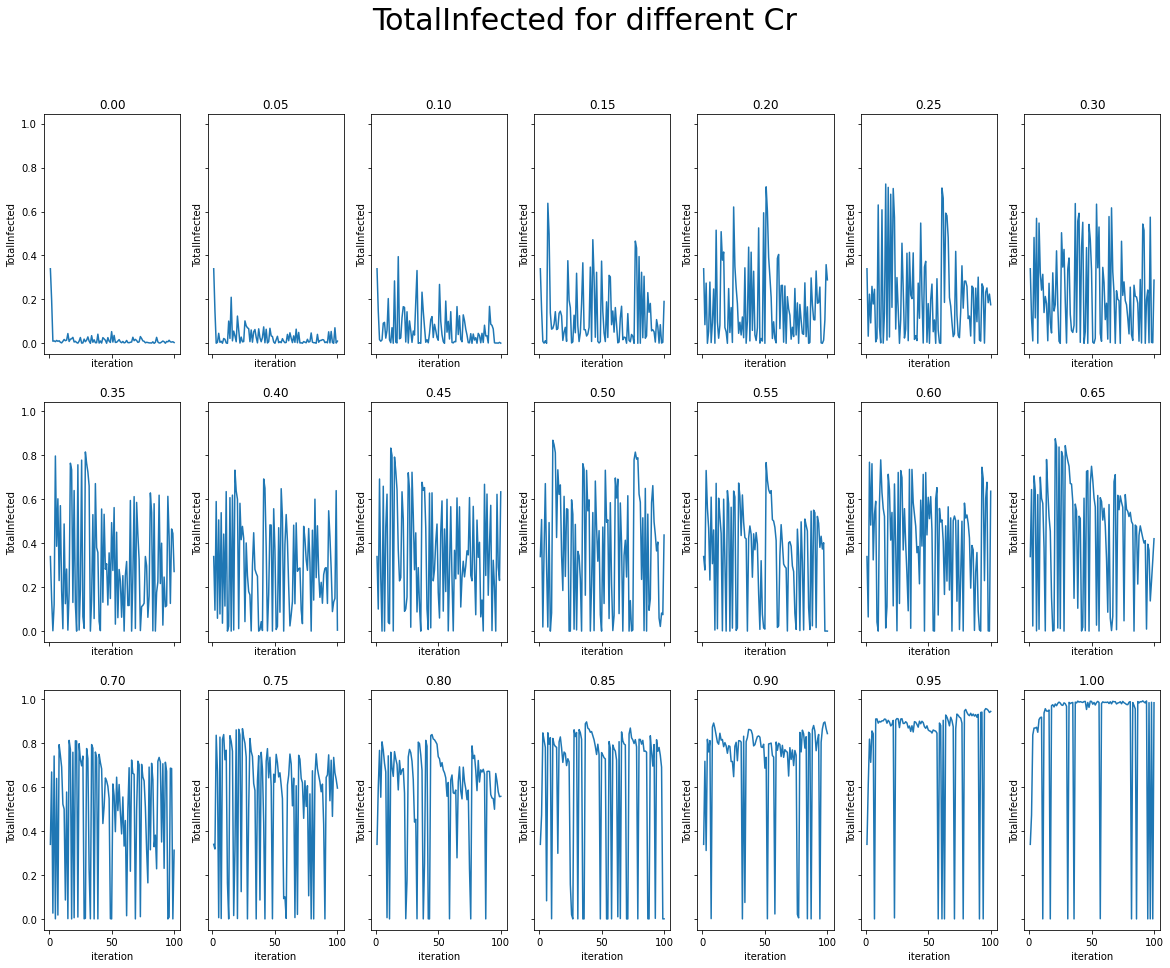

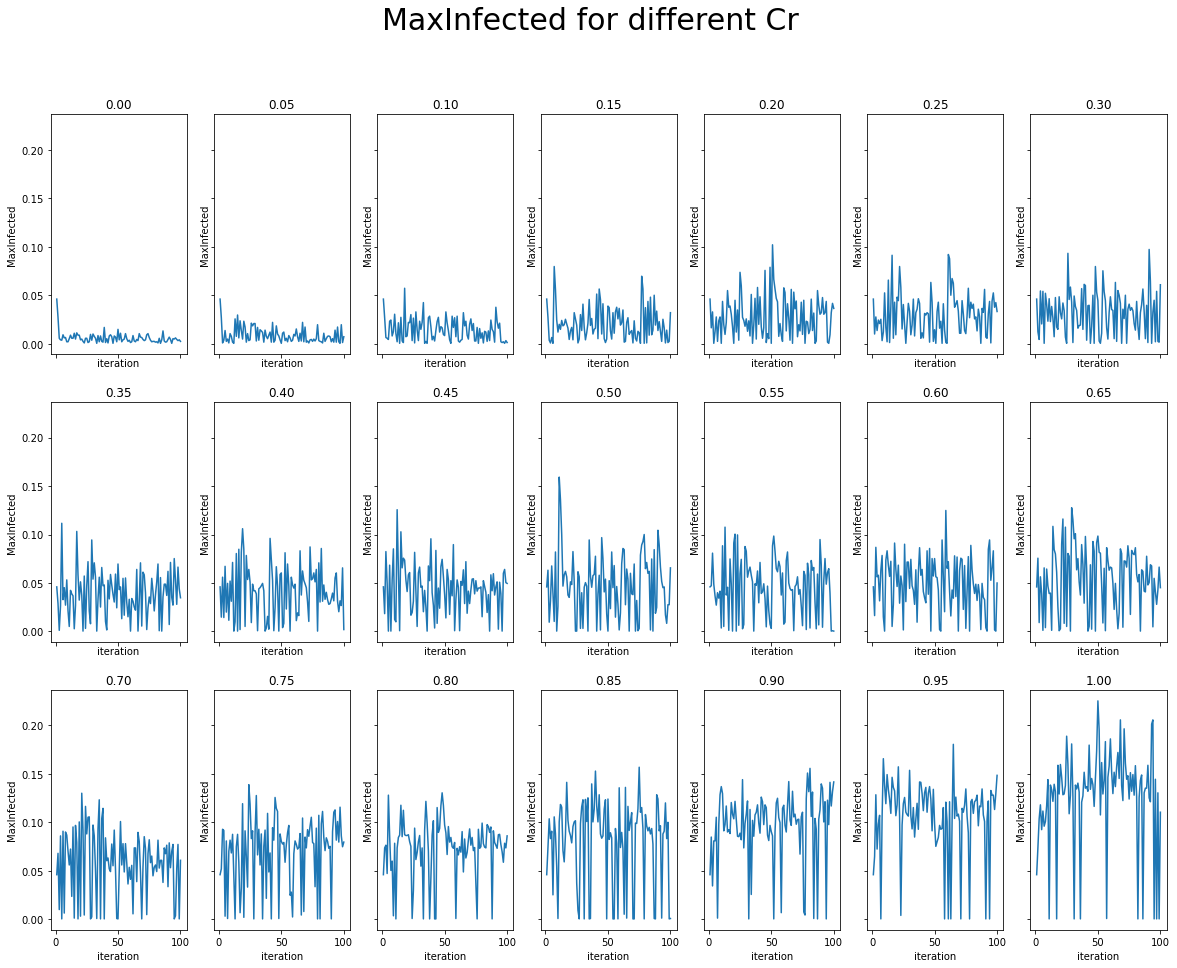

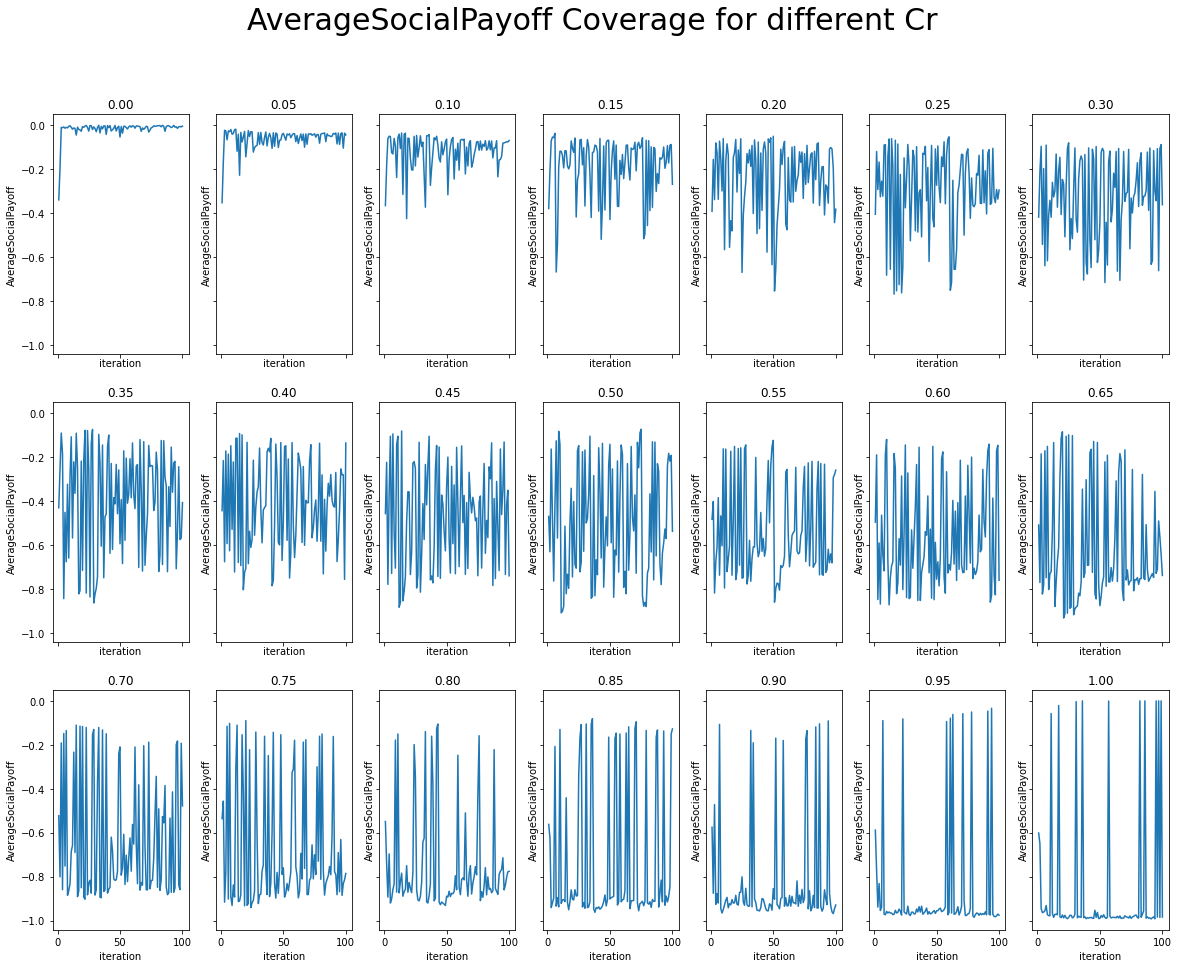

In [8]:
plot_list_dataframes_vs_iteration(dataframes_SB_RA, 'VaccineCoverage', Cr_list_str, 'SB_RA', 'Vaccine Coverage for different Cr')
plot_list_dataframes_vs_iteration(dataframes_SB_RA, 'TotalInfected', Cr_list_str, 'SB_RA' , 'TotalInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_SB_RA, 'MaxInfected', Cr_list_str,  'SB_RA' , 'MaxInfected for different Cr')
plot_list_dataframes_vs_iteration(dataframes_SB_RA, 'AverageSocialPayoff', Cr_list_str, 'SB_RA' , 'AverageSocialPayoff Coverage for different Cr')

# Final databases

In [9]:
#keep only last 80 iterations

IB_RA_VaccineCoverage_means = []
IB_RA_TotalInfected_means = []
IB_RA_MaxInfected_means = []
IB_RA_AverageSocialPayoff_means = []

SB_RA_VaccineCoverage_means = []
SB_RA_TotalInfected_means = []
SB_RA_MaxInfected_means = []
SB_RA_AverageSocialPayoff_means = []

IB_RA_df_definitive = [single_df[single_df.loc[:,'Iteration'] >= 20.].reset_index() for single_df in dataframes_IB_RA]
SB_RA_df_definitive = [single_df[single_df.loc[:,'Iteration'] >= 20.].reset_index() for single_df in dataframes_SB_RA]


for single_df in IB_RA_df_definitive:
    IB_RA_VaccineCoverage_means.append    (single_df.loc[:,'VaccineCoverage'].mean())
    IB_RA_TotalInfected_means.append      (single_df.loc[:,'TotalInfected'].mean())
    IB_RA_MaxInfected_means.append        (single_df.loc[:,'MaxInfected'].mean())
    IB_RA_AverageSocialPayoff_means.append(single_df.loc[:,'AverageSocialPayoff'].mean())
    
for single_df in SB_RA_df_definitive:
    SB_RA_VaccineCoverage_means.append    (single_df.loc[:,'VaccineCoverage'].mean())
    SB_RA_TotalInfected_means.append      (single_df.loc[:,'TotalInfected'].mean())
    SB_RA_MaxInfected_means.append        (single_df.loc[:,'MaxInfected'].mean())
    SB_RA_AverageSocialPayoff_means.append(single_df.loc[:,'AverageSocialPayoff'].mean())

# Final Plots

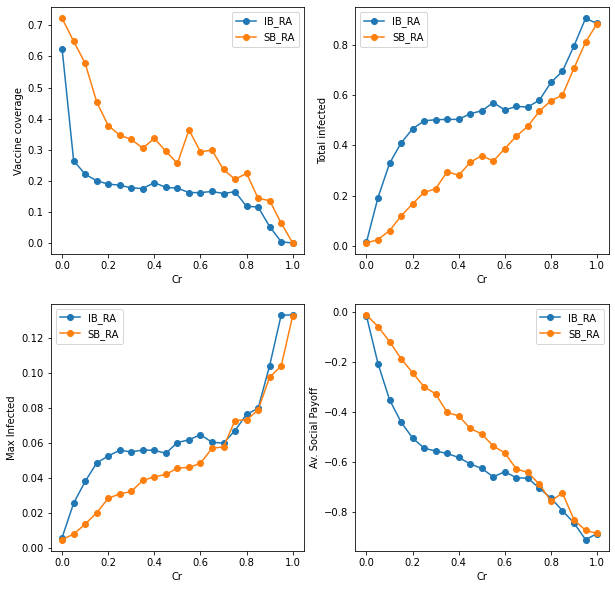

In [10]:
fig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0,0].plot(Cr_list, np.array(IB_RA_VaccineCoverage_means), 'o-' , label = 'IB_RA')
ax[0,0].plot(Cr_list, np.array(SB_RA_VaccineCoverage_means), 'o-' , label = 'SB_RA')
ax[0,0].set_ylabel('Vaccine coverage')

ax[0,1].plot(Cr_list, np.array(IB_RA_TotalInfected_means), 'o-' , label = 'IB_RA')
ax[0,1].plot(Cr_list, np.array(SB_RA_TotalInfected_means), 'o-' , label = 'SB_RA')
ax[0,1].set_ylabel('Total infected')

ax[1,0].plot(Cr_list, np.array(IB_RA_MaxInfected_means), 'o-' , label = 'IB_RA')
ax[1,0].plot(Cr_list, np.array(SB_RA_MaxInfected_means), 'o-' , label = 'SB_RA')
ax[1,0].set_ylabel('Max Infected')

ax[1,1].plot(Cr_list, np.array(IB_RA_AverageSocialPayoff_means), 'o-' , label = 'IB_RA')
ax[1,1].plot(Cr_list, np.array(SB_RA_AverageSocialPayoff_means), 'o-' , label = 'SB_RA')
ax[1,1].set_ylabel('Av. Social Payoff')

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Cr')
        ax[i,j].legend()

plt.savefig('Results')

# Prove del codice

In [ ]:
#initialization
N = 50
timesteps = 5
G = nx.grid_2d_graph(N, N)
G = nx.convert_node_labels_to_integers(G)
strategy = nx.number_of_nodes(G)*['S']

# totally random
for i in range(2000):
    seed = np.random.choice(range(len(strategy)))
    strategy[seed] = 'V'
print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))

init_strat = strategy.copy()
vaccine_fraction_IB_RA = []
vaccine_fraction_IB_RA.append(strategy.count('V')/(N*N))
total_infected_IB_RA = []


columns = ['Iteration', 'VaccineCoverage', 'TotalInfected', 'MaxInfected', 'AverageSocialPayoff']
results = pd.DataFrame(columns=columns)
vacc_cover   = strategy.count('V')/(N*N)
total_infec  = df.tail(1).R.values[0]
av_payoff    = mean(payoffs_values)
max_infected = max(df.I)
results.loc[len(results)] = [i, vacc_cover, total_infec, max_infected, av_payoff]



#dynamics using IB_RA update
for i in range(timesteps):
    print(i,"/",timesteps)
    df, statuses   = gillespieSIRV(G, 1, 0.4, 1000, strategy)
    total_infected_IB_RA.append(df.tail(1).R.values[0])
    payoffs_values = get_payoff(statuses, 0.2, N)
    new_strategies = IB_RA_update(strategy, payoffs_values, G)
    strategy       = new_strategies.copy()
    vaccine_fraction_IB_RA.append(strategy.count('V')/(N*N))


plot_strategy_square_lattice(init_strat, N, "Initial")
plot_strategy_square_lattice(strategy, N, "Final")

In [ ]:
#initialization
N = 50
G = nx.grid_2d_graph(N, N)
G = nx.convert_node_labels_to_integers(G)
strategy = nx.number_of_nodes(G)*['S']

# totally random
for i in range(2000):
    seed = np.random.choice(range(len(strategy)))
    strategy[seed] = 'V'
print("Fraction of population vaccinated is:", strategy.count('V')/(N*N))

init_strat = strategy.copy()
vaccine_fraction_SB_RA = []
vaccine_fraction_SB_RA.append(strategy.count('V')/(N*N))
total_infected_SB_RA = []

#dynamics using SB_RA update
for i in range(timesteps):
    print(i,"/",timesteps)
    df, statuses   = gillespieSIRV(G, 1, 0.4, 1000, strategy)
    total_infected_SB_RA.append(df.tail(1).R.values[0])
    payoffs_values = get_payoff(statuses, 0.2, N)
    new_strategies = SB_RA_update(strategy, payoffs_values, G, 0)
    strategy = new_strategies.copy()
    vaccine_fraction_SB_RA.append(strategy.count('V')/(N*N))
    
plot_strategy_square_lattice(init_strat, N, "Initial")
plot_strategy_square_lattice(strategy, N, "Final")

In [ ]:
plt.plot(np.arange(timesteps + 1), np.array(vaccine_fraction_IB_RA), label = 'IB_RA')
plt.plot(np.arange(timesteps + 1), np.array(vaccine_fraction_SB_RA), label = 'SB_RA')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('Vaccination coverage')
plt.title('Vaccination coverage vs Timestep')
plt.show()


plt.plot(np.arange(timesteps), np.array(total_infected_IB_RA), label = 'IB_RA')
plt.plot(np.arange(timesteps), np.array(total_infected_SB_RA), label = 'SB_RA')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('Infected vs timestep')
plt.title('Infected fraction vs Timestep')
plt.show()

fig, ax = plt.subplots(1,2, figsize = (12,8))
ax[0].plot(np.arange(timesteps), np.array(vaccine_fraction_IB_RA)[:-1], label = 'vaccine coverage')
ax[0].plot(np.arange(timesteps), np.array(total_infected_IB_RA), label = 'total infected')
ax[0].set_xlabel('timestep')
ax[0].set_ylabel('fraction')
ax[0].set_title("IB_RA strategy update")
ax[0].legend()


ax[1].plot(np.arange(timesteps), np.array(vaccine_fraction_SB_RA)[:-1], label = 'vaccine coverage')
ax[1].plot(np.arange(timesteps), np.array(total_infected_SB_RA), label = 'total infected')
ax[1].set_xlabel('timestep')
ax[1].set_ylabel('fraction')
ax[1].set_title("SB_RA strategy update")
ax[1].legend()
plt.show()

In [ ]:
plot_SIRV_results_square_lattice(statuses, N)

In [ ]:
for i in G.neighbors(55):
    print(i)

In [ ]:
plt.plot(datas.Time, datas.S, label = 'S')
plt.plot(datas.Time, datas.I, label = 'I')
plt.plot(datas.Time, datas.R, label = 'R')
plt.legend()
plt.show()

In [ ]:
datas

In [ ]:
lista_statuses     = 15*['S']
lista_statuses[12] = 'V'
lista_statuses[5]  = 'V'
lista_statuses[10] = 'V'

lista_statuses.count('S')

In [ ]:
statuses = nx.number_of_nodes(G)*['S']
for i in range(100):
    seed = np.random.choice(range(len(statuses)))
    statuses[seed] = 'V'

In [ ]:
df, statuses = gillespieSIRV(G, 0.5, 0.2, 40, statuses)
#https://stackoverflow.com/questions/10194482/custom-matplotlib-plot-chess-board-like-table-with-colored-cells

In [ ]:
#https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values
def find_colour(_val):
    # Colour value constants
    _colours = {"blue": [0.0, 0.0, 1.0],
                "green": [0.0, 1.0, 0.00],
                "yellow": [1.0, 1.0, 0.0],
                "red": [1.0, 0.0, 0.0]}

    # Map the value to a colour
    _colour = [0, 0, 0]
    if _val == 'V':
        _colour = _colours["blue"]
    elif _val == 'S':
        _colour = _colours["green"]
    elif _val == 'I':
        _colour = _colours["yellow"]
    elif _val == 'R':
        _colour = _colours["red"]

    return tuple(_colour)

colors = find_colour(statuses[0])
colors

In [ ]:
#map statuses to color
# V -> 0
# S -> 1
# I -> 2
# R -> 3

def map_status_to_value(statuses_list):
    vals = []
    for i in statuses_list:
        if i == 'V':
            vals.append(0)
        elif i == 'S':
            vals.append(1)
        elif i == 'I':
            vals.append(2)
        elif i == 'R':
            vals.append(3)
        
    return np.array(vals)

values = map_status_to_value(statuses).reshape((N,N))

cMap = ListedColormap(['blue', 'green', 'yellow','red'])
# bounds = [-0.1,0.9,1.9,2.9,3.9]
# norm = colors.BoundaryNorm(bounds, cmap.N)

In [ ]:
# create discrete colormap
fig, ax = plt.subplots(figsize = (10,10))
img = ax.imshow(values, cmap=cMap)

#legend
cbar = plt.colorbar(img)
#empty the ticks of cbar
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['V', 'S', 'I', 'R']):
    cbar.ax.text(1.5, 0.75*j+0.35, lab, ha='center', va ='center', fontsize = '25')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Node type', rotation=90, fontsize = '25')

ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xlim([-.5,float(N)-0.5])
ax.set_ylim([-.5,float(N)-0.5])

labels = [str(i) for i in range(N)]
ax.set_xticks(np.arange(-.5, N , 1))
ax.set_yticks(np.arange(-.5, N , 1))

empty_string_labels = ['']*len(np.arange(-.5, N , 1))
ax.set_xticklabels(empty_string_labels)
ax.set_yticklabels(empty_string_labels)
ax.invert_yaxis()
plt.title('SIRV - final snapshot', fontsize = '25')
plt.show()

In [ ]:
def map_status_to_value(statuses_list):
    vals = []
    for i in statuses_list:
        if i == 'V':
            vals.append(0)
        elif i == 'S':
            vals.append(1)
        elif i == 'I':
            vals.append(2)
        elif i == 'R':
            vals.append(3)
        
    return np.array(vals)


def plot_SIRV_results(values):
    
    values = map_status_to_value(statuses).reshape((N,N))
    cMap = ListedColormap(['blue', 'green', 'yellow','red'])
    
    fig, ax = plt.subplots(figsize = (10,10))
    img = ax.imshow(values, cmap=cMap)

    #legend
    cbar = plt.colorbar(img)
    #empty the ticks of cbar
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['V', 'S', 'I', 'R']):
        cbar.ax.text(1.5, 0.75*j+0.35, lab, ha='center', va ='center', fontsize = '25')
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Node type', rotation=90, fontsize = '25')

    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xlim([-.5,float(N)-0.5])
    ax.set_ylim([-.5,float(N)-0.5])

    labels = [str(i) for i in range(N)]
    ax.set_xticks(np.arange(-.5, N , 1))
    ax.set_yticks(np.arange(-.5, N , 1))

    empty_string_labels = ['']*len(np.arange(-.5, N , 1))
    ax.set_xticklabels(empty_string_labels)
    ax.set_yticklabels(empty_string_labels)
    ax.invert_yaxis()
    plt.title('SIRV - final snapshot', fontsize = '25')
    plt.show()